In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt, seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/sales_train.csv')
shop = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/shops.csv')
item = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/items.csv')
itemc = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/item_categories.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')

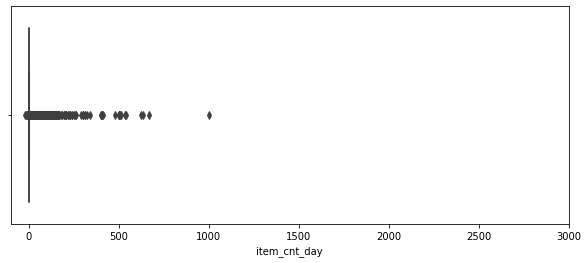

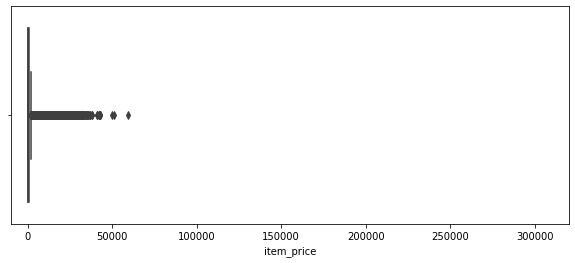

In [4]:
#date is changed from day.month.year to year-month-day 
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: ((x+1) % 12))

#delete outliers
train = train[train['item_cnt_day'] < 1001]
train = train[train['item_price'] < 300000]

#plot train data after delete outliers 
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x=train['item_price'])

#The data has item_price value less than zero, it's incorrect. We make item_price be median.
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train['item_price']<0,'item_price'] = median

In [6]:
selected_features = ['shop_id', 'item_id']
X_train = train[selected_features]
X_test = test[selected_features]
y_train = train['item_cnt_day']

from sklearn.ensemble import GradientBoostingRegressor
rfr = GradientBoostingRegressor()
reg=rfr.fit(X_train, y_train)

from math import sqrt
from sklearn.metrics import mean_squared_error
num = sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print(num)
test1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')
rfr_y_predict2 = rfr.predict(X_test)

rfr_submission = pd.DataFrame({'ID': test1['ID'], 'item_cnt_month': rfr_y_predict2})
rfr_submission.to_csv('submission.csv', index=False,sep=',')

2.206248531510482


In [7]:
dd = pd.read_csv('submission.csv')
dd

,ID,item_cnt_month
0,0,1.091011
1,1,1.091011
2,2,1.091011
3,3,1.091011
4,4,1.091011
...,...,...
214195,214195,1.062146
214196,214196,1.078405
214197,214197,1.078405
214198,214198,1.062146


In [8]:
del train['date']
del train['item_price']
train

,date_block_num,shop_id,item_id,item_cnt_day,year,month
0,0,59,22154,1.0,2013,1
1,0,25,2552,1.0,2013,1
2,0,25,2552,-1.0,2013,1
3,0,25,2554,1.0,2013,1
4,0,25,2555,1.0,2013,1
...,...,...,...,...,...,...
2935844,33,25,7409,1.0,2015,10
2935845,33,25,7460,1.0,2015,10
2935846,33,25,7459,1.0,2015,10
2935847,33,25,7440,1.0,2015,10


In [9]:
del test['ID']
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test = test[['date_block_num','shop_id','item_id','year','month']]
test 

,date_block_num,shop_id,item_id,year,month
0,34,5,5037,2015,11
1,34,5,5320,2015,11
2,34,5,5233,2015,11
3,34,5,5232,2015,11
4,34,5,5268,2015,11
...,...,...,...,...,...
214195,34,45,18454,2015,11
214196,34,45,16188,2015,11
214197,34,45,15757,2015,11
214198,34,45,19648,2015,11


In [10]:
#lstm train
X_train = train[train.date_block_num < 33].drop(['item_cnt_day'], axis=1)
X_train = np.expand_dims(train.values[:, :-1], axis=2)
Y_train = train[train.date_block_num < 33]['item_cnt_day']
Y_train = train.values[:, -1:]
X_valid = train[train.date_block_num == 33].drop(['item_cnt_day'], axis=1)
X_valid = np.expand_dims(train.values[:, :-1], axis=2)
Y_valid = train[train.date_block_num == 33]['item_cnt_day']
Y_valid = train.values[:, -1:]
X_test = test
X_test = np.expand_dims(test.values[:, 1:], axis=2)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model_kaggle_lstm = Sequential()
model_kaggle_lstm .add(LSTM(units=64, input_shape=(5,1)))
model_kaggle_lstm .add(Dropout(0.3))
model_kaggle_lstm .add(Dense(1))

model_kaggle_lstm .compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])

model_kaggle_lstm .summary()

from keras.callbacks import EarlyStopping

callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]

history = model_kaggle_lstm .fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=4096, epochs=50,callbacks=callbacks_list)
model_kaggle_lstm .save('lstm.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
717/717 [==============================] - 128s 175ms/step - loss: 12.8838 - mean_squared_error: 12.8838 - val_loss: 9.1051 - val_mean_squared_error: 9.1051
Epoch 2/50
717/717 [==============================] - 118s 165ms/step - loss: 6.0077 - mean_squared_error: 6.0077 - val_loss: 2.3009 - val_mean_squa

In [11]:
#lstm predict
X_test = test
X_test = np.expand_dims(test.values[:, :], axis=2)
from keras.models import load_model
test1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')
#X_test = np.expand_dims(test.values[:, 1:], axis=2)

model = load_model('lstm.h5')

LSTM_prediction = model.predict(X_test[:,-5:,:])
LSTM_prediction = np.round(LSTM_prediction,2)
LSTM_prediction = LSTM_prediction.clip(0, 20)

submission = pd.DataFrame({'ID': test1['ID'], 'item_cnt_month': LSTM_prediction.ravel()})
submission.to_csv('lstm_submission.csv',index=False)

In [12]:
ds = pd.read_csv('lstm_submission.csv')
ds

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0


In [15]:
!pip install Adam
!pip install SGD
!pip install RMSprop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement SGD (from versions: none)
ERROR: No matching distribution found for SGD
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement RMSprop (from versions: none)
ERROR: No matching distribution found for RMSprop


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

In [18]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_day'], axis=1)
X_train = np.expand_dims(train.values[:, :-1], axis=2)
Y_train = train[train.date_block_num < 33]['item_cnt_day']
Y_train = train.values[:, -1:]
X_valid = train[train.date_block_num == 33].drop(['item_cnt_day'], axis=1)
X_valid = np.expand_dims(train.values[:, :-1], axis=2)
Y_valid = train[train.date_block_num == 33]['item_cnt_day']
Y_valid = train.values[:, -1:]
X_test = test
X_test = np.expand_dims(test.values[:, :], axis=2)

In [19]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(5,1),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 16)             1152      
                                                                 
 dropout (Dropout)           (None, 5, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainabl

Epoch 1/10
1434/1434 [==============================] - 120s 81ms/step - loss: 10.7913 - mse: 10.7913 - val_loss: 7.3116 - val_mse: 7.3116
Epoch 2/10
1434/1434 [==============================] - 113s 79ms/step - loss: 5.0604 - mse: 5.0604 - val_loss: 1.6094 - val_mse: 1.6094
Epoch 3/10
1434/1434 [==============================] - 110s 77ms/step - loss: 2.2836 - mse: 2.2836 - val_loss: 0.3680 - val_mse: 0.3680
Epoch 4/10
1434/1434 [==============================] - 112s 78ms/step - loss: 1.5495 - mse: 1.5495 - val_loss: 0.2726 - val_mse: 0.2726
Epoch 5/10
1434/1434 [==============================] - 109s 76ms/step - loss: 1.2375 - mse: 1.2375 - val_loss: 0.1773 - val_mse: 0.1773
Epoch 6/10
1434/1434 [==============================] - 111s 77ms/step - loss: 1.4096 - mse: 1.4096 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 7/10
1434/1434 [==============================] - 109s 76ms/step - loss: 1.0582 - mse: 1.0582 - val_loss: 0.1240 - val_mse: 0.1240
Epoch 8/10
1434/1434 [=================

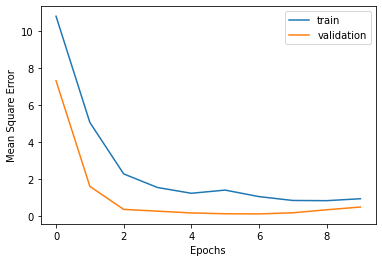

<Figure size 432x288 with 0 Axes>

In [20]:
LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":10}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),callbacks=callbacks_list, **LSTM_PARAM)
pred = model_lstm.predict(X_test)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [21]:
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub.csv',index_label='ID')

In [22]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub.csv')
df

,ID,item_cnt_month
0,0,8.957566
1,1,8.957566
2,2,8.957566
3,3,8.957566
4,4,8.957566
...,...,...
214195,214195,8.852759
214196,214196,8.852759
214197,214197,8.852759
214198,214198,8.852759


In [23]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

In [24]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_day'], axis=1)
Y_train = train[train.date_block_num < 33]['item_cnt_day']
X_valid = train[train.date_block_num == 33].drop(['item_cnt_day'], axis=1)
Y_valid = train[train.date_block_num == 33]['item_cnt_day']
X_test = test

In [25]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[12:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.33461	validation_1-rmse:2.84171
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.30253	validation_1-rmse:2.80739
[2]	validation_0-rmse:2.26493	validation_1-rmse:2.7791
[3]	validation_0-rmse:2.2396	validation_1-rmse:2.75675
[4]	validation_0-rmse:2.2183	validation_1-rmse:2.74112
[5]	validation_0-rmse:2.2012	validation_1-rmse:2.72987
[6]	validation_0-rmse:2.1948	validation_1-rmse:2.71832
[7]	validation_0-rmse:2.1804	validation_1-rmse:2.70958
[8]	validation_0-rmse:2.17566	validation_1-rmse:2.70435
[9]	validation_0-rmse:2.16446	validation_1-rmse:2.69864
[10]	validation_0-rmse:2.15454	validation_1-rmse:2.69741
[11]	validation_0-rmse:2.14599	validation_1-rmse:2.69642
[12]	validation_0-rmse:2.13978	validation_1-rm

120.56152200698853

In [26]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission.csv', index=False)

In [27]:
dl = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission.csv')
dl

,ID,item_cnt_month
0,0,1.040117
1,1,1.040117
2,2,1.040117
3,3,1.040117
4,4,1.040117
...,...,...
214195,214195,1.009305
214196,214196,1.028680
214197,214197,1.028680
214198,214198,1.014394
